### In this notebook we test the top three combinations as given by the Automated Imbalanced Classification Approach.
### This code was executed on Google Collab, so it is not edited right now for running on jupyter notebook on a local machine. But it can be executed on Google Collab..

In [ ]:
!pip install dask[dataframe]


Evaluating Pipeline 1: RandomOverSampler + XGBClassifier


Pipeline Progress:  67%|██████▋   | 2/3 [00:04<00:01,  1.87s/step]

After sampling, class distribution in y_train: Counter({0: 700769, 1: 700769})


Pipeline Progress: 100%|██████████| 3/3 [00:05<00:00,  1.52s/step]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:54:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Pipeline Progress: 100%|██████████| 3/3 [00:06<00:00,  2.09s/step]


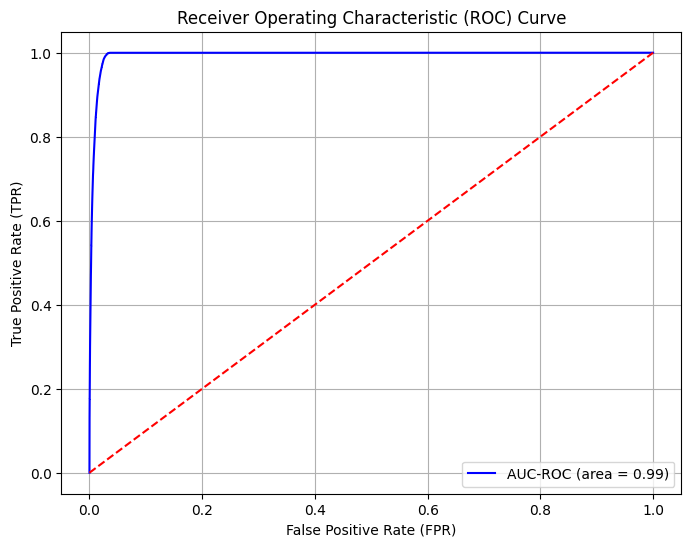

              Metric     Value
0           Accuracy  0.972218
1          Precision  0.774463
2             Recall  0.995178
3           F1 Score  0.871056
4            AUC-ROC  0.994719
5           Log Loss  0.078279
6  Balanced Accuracy  0.982503

Evaluating Pipeline 2: RandomOverSampler + LGBMClassifier


Pipeline Progress:  67%|██████▋   | 2/3 [00:04<00:01,  1.87s/step]

After sampling, class distribution in y_train: Counter({0: 700769, 1: 700769})
[LightGBM] [Info] Number of positive: 700769, number of negative: 700769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 1401538, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline Progress: 100%|██████████| 3/3 [00:09<00:00,  3.02s/step]


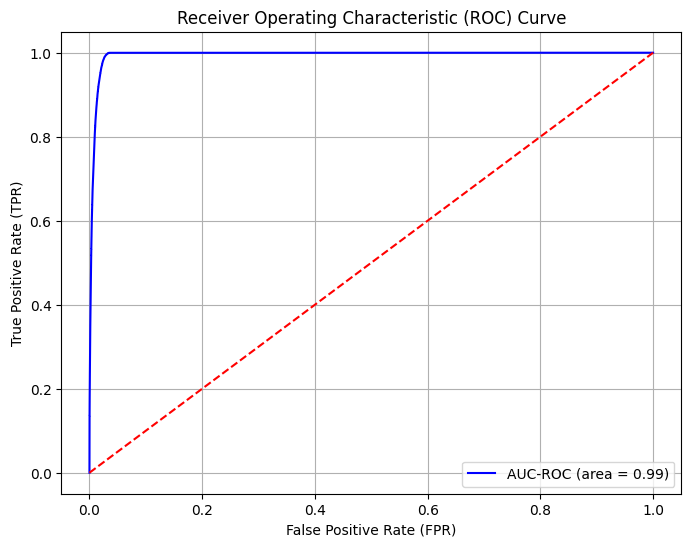

              Metric     Value
0           Accuracy  0.971213
1          Precision  0.767274
2             Recall  0.997163
3           F1 Score  0.867242
4            AUC-ROC  0.994705
5           Log Loss  0.080124
6  Balanced Accuracy  0.982837

Evaluating Pipeline 3: SMOTE + LGBMClassifier


Pipeline Progress:  67%|██████▋   | 2/3 [00:11<00:06,  6.02s/step]

After sampling, class distribution in y_train: Counter({0: 700769, 1: 700769})
[LightGBM] [Info] Number of positive: 700769, number of negative: 700769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4095
[LightGBM] [Info] Number of data points in the train set: 1401538, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline Progress: 100%|██████████| 3/3 [00:15<00:00,  5.23s/step]


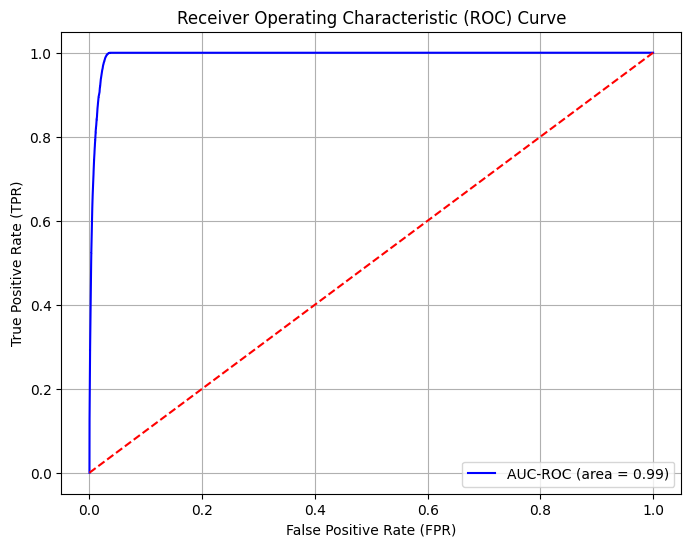

              Metric     Value
0           Accuracy  0.973379
1          Precision  0.785064
2             Recall  0.988249
3           F1 Score  0.875016
4            AUC-ROC  0.994115
5           Log Loss  0.071314
6  Balanced Accuracy  0.980040


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix as sklearn_cm, log_loss, balanced_accuracy_score, roc_curve)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from collections import Counter
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Load the data
# You need to mount your drive in the Collab notebook and replace this data_path with your own. 
# You have to upload the complete data on google drive first.
data_path = "/content/drive/MyDrive/Hackathons@TeamKuleli/GST Prediction Model/complete_data"
X_train = pd.read_csv(f'{data_path}/X_Train_Data_Input.csv')
Y_train = pd.read_csv(f'{data_path}/Y_Train_Data_Target.csv')
X_test = pd.read_csv(f'{data_path}/X_Test_Data_Input.csv')
Y_test = pd.read_csv(f'{data_path}/Y_Test_Data_Target.csv')

# Remove 'ID' column and duplicates
X_train = X_train.drop(columns=['ID'], axis=1).drop_duplicates()
X_test = X_test.drop(columns=['ID'], axis=1)

# Separate features and target
y_train = X_train['target']
X_train = X_train.drop('target', axis=1)

y_test = X_test['target']
X_test = X_test.drop('target', axis=1)

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing: Handle missing values and scaling within the pipeline
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
encoder = OrdinalEncoder()

# Multicollinearity handling
def drop_high_correlation(X, threshold=0.9):
    """Drops highly correlated features in X"""
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop, axis=1), to_drop

# Custom preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', encoder)]), categorical_cols)
    ]
)

# Function to evaluate models
def evaluate_model_tabular(pipeline, X_train, y_train, X_test, y_test):
    steps = len(pipeline.steps)
    progress_bar = tqdm(total=steps, desc="Pipeline Progress", unit="step")

    # Fit and transform each step manually
    for name, step in pipeline.steps[:-1]:
        if hasattr(step, 'fit_resample'):
            X_train, y_train = step.fit_resample(X_train, y_train)
            print(f"After {name}, class distribution in y_train: {Counter(y_train)}")
        elif hasattr(step, 'fit'):
            step.fit(X_train, y_train)
        progress_bar.update(1)

        if hasattr(step, 'transform'):
            X_train = step.transform(X_train)
            X_test = step.transform(X_test)

    # Final step: Classifier
    classifier_name, classifier = pipeline.steps[-1]
    classifier.fit(X_train, y_train)
    progress_bar.update(1)

    # Prediction
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = sklearn_cm(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Log Loss', 'Balanced Accuracy'],
        'Value': [accuracy, precision, recall, f1, auc, logloss, balanced_acc]
    })

    progress_bar.close()

    # Plot AUC-ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return metrics_df, cm, {'fpr': fpr, 'tpr': tpr}

# XGBoost Pipeline (Pipeline 1)
ros = RandomOverSampler(random_state=42)
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss'
)
pipeline1 = ImbPipeline(steps=[('preprocessing', preprocessor), ('sampling', ros), ('classification', xgb_model)])

# LGBM (CPU) Pipeline (Pipeline 2)
lgbm_model = lgb.LGBMClassifier(device_type='cpu', random_state=42)
pipeline2 = ImbPipeline(steps=[('preprocessing', preprocessor), ('sampling', ros), ('classification', lgbm_model)])

# SMOTE + LGBM Pipeline (Pipeline 3)
smote = SMOTE(random_state=42)
lgbm_model2 = lgb.LGBMClassifier(device_type='cpu', random_state=42, n_jobs=-1)  # Multi-threading enabled
pipeline3 = ImbPipeline(steps=[('preprocessing', preprocessor), ('sampling', smote), ('classification', lgbm_model2)])

# Evaluate Pipeline 1
print('\nEvaluating Pipeline 1: RandomOverSampler + XGBClassifier')
metrics_table, confusion_matrix, roc_curve_values = evaluate_model_tabular(pipeline1, X_train, y_train, X_test, y_test)
print(metrics_table)

# Evaluate Pipeline 2
print('\nEvaluating Pipeline 2: RandomOverSampler + LGBMClassifier')
metrics_table, confusion_matrix, roc_curve_values = evaluate_model_tabular(pipeline2, X_train, y_train, X_test, y_test)
print(metrics_table)

# Evaluate Pipeline 3
print('\nEvaluating Pipeline 3: SMOTE + LGBMClassifier')
metrics_table, confusion_matrix, roc_curve_values = evaluate_model_tabular(pipeline3, X_train, y_train, X_test, y_test)
print(metrics_table)


### So via this we concluded that our third combination which is SMOTE + LGBMClassifier' gives us the best performance metric, and hence we are going to pursue it in our final testing.